# Product Ranking for Upselling

## Objective
Create a ranking system for product recommendations based on **Expected Value**:

$$\text{Expected Value} = P(\text{purchase}) \times \text{Price}$$

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.insert(0, str(Path.cwd().parent / 'src'))
from data_loader import load_raw_data, SAUCES

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)
print('Setup complete!')

Setup complete!


## 1. Load Data

In [2]:
DATA_PATH = Path('../data/raw/ap_dataset.csv')
df = load_raw_data(DATA_PATH)
total_receipts = df['id_bon'].nunique()
print(f"Dataset: {len(df)} rows, {total_receipts} receipts")

Dataset: 28039 rows, 7869 receipts


In [3]:
# Calculate product statistics (FAST - uses groupby)
product_stats = df.groupby('retail_product_name').agg(
    receipt_count=('id_bon', 'nunique'),
    price=('SalePriceWithVAT', 'first')
).reset_index()
product_stats.columns = ['product', 'receipt_count', 'price']
product_stats['purchase_probability'] = product_stats['receipt_count'] / total_receipts
product_stats['expected_value'] = product_stats['purchase_probability'] * product_stats['price']
product_stats = product_stats.sort_values('expected_value', ascending=False)

print("Top 10 Products by Expected Value:")
product_stats.head(10)

Top 10 Products by Expected Value:


,product,receipt_count,price,purchase_probability,expected_value
37,Mac & cheease,2233,32.9,0.283772,9.336091
6,Breaded Chicken Schnitzel,1946,27.9,0.247300,6.899657
16,Crazy Schnitzel,1783,28.9,0.226585,6.548316
58,Viennese Schnitzel,675,48.9,0.085780,4.194624
35,Mac & Cheese with Crispy Bacon,1146,25.9,0.145635,3.771941
4,Baked potatoes,1809,12.9,0.229889,2.965574
38,Margherita Pizza Schnitzel,466,47.9,0.059220,2.836625
42,Pepsi Cola 0.25L Doze,1682,12.0,0.213750,2.565002
13,Crazy Fries with Parmesan,584,24.9,0.074215,1.847960
2,Aqua Carpatica Plata 0.5L,1526,9.5,0.193926,1.842293


## 2. General Upsell Ranking

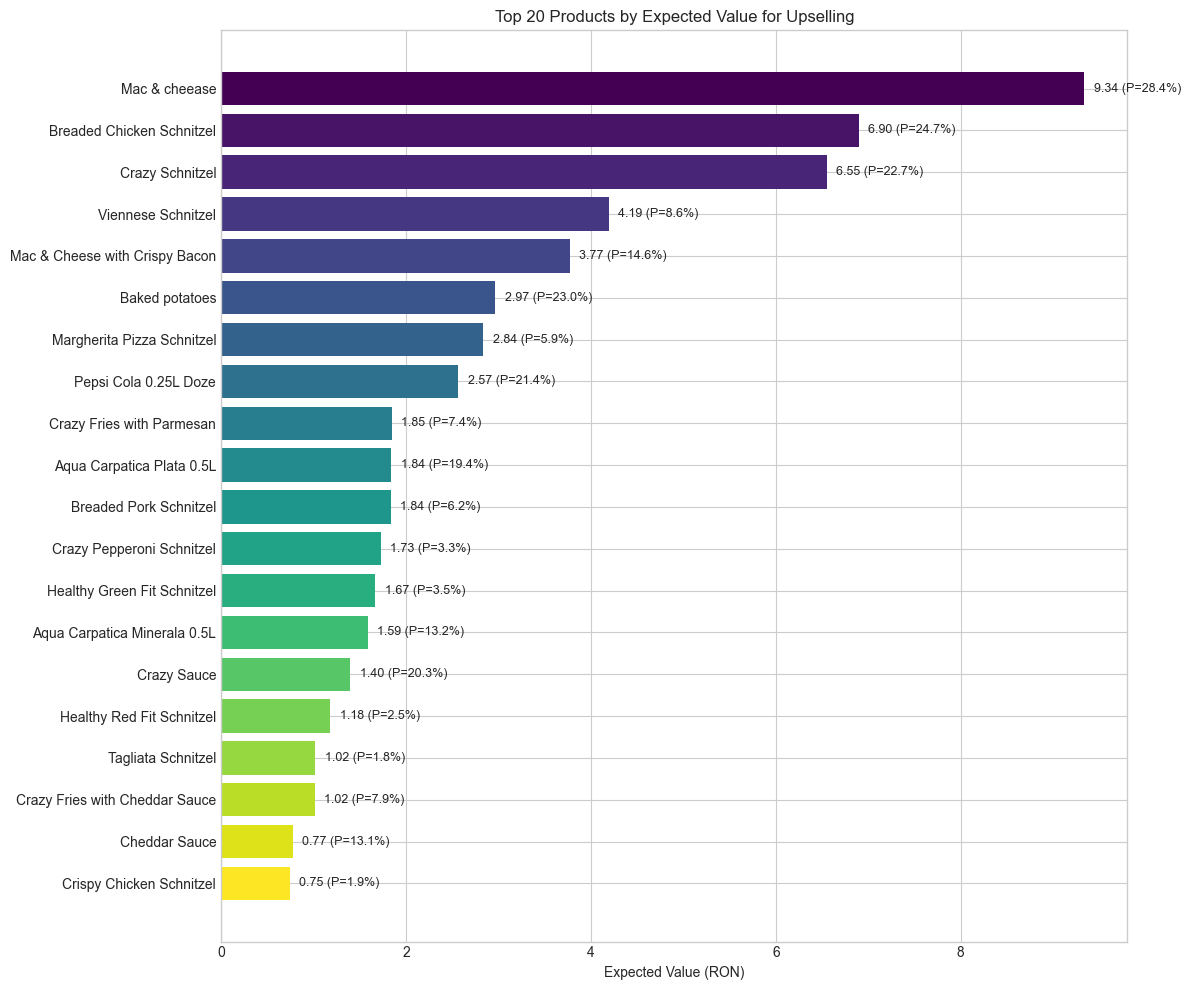

Saved: ranking_expected_value.png


In [4]:
# Top 20 products visualization
top_20 = product_stats.head(20)

fig, ax = plt.subplots(figsize=(12, 10))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_20)))
ax.barh(range(len(top_20)), top_20['expected_value'], color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['product'])
ax.set_xlabel('Expected Value (RON)')
ax.set_title('Top 20 Products by Expected Value for Upselling')
ax.invert_yaxis()
for i, (v, p) in enumerate(zip(top_20['expected_value'], top_20['purchase_probability'])):
    ax.text(v + 0.1, i, f'{v:.2f} (P={p:.1%})', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('../results/ranking_expected_value.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: ranking_expected_value.png')

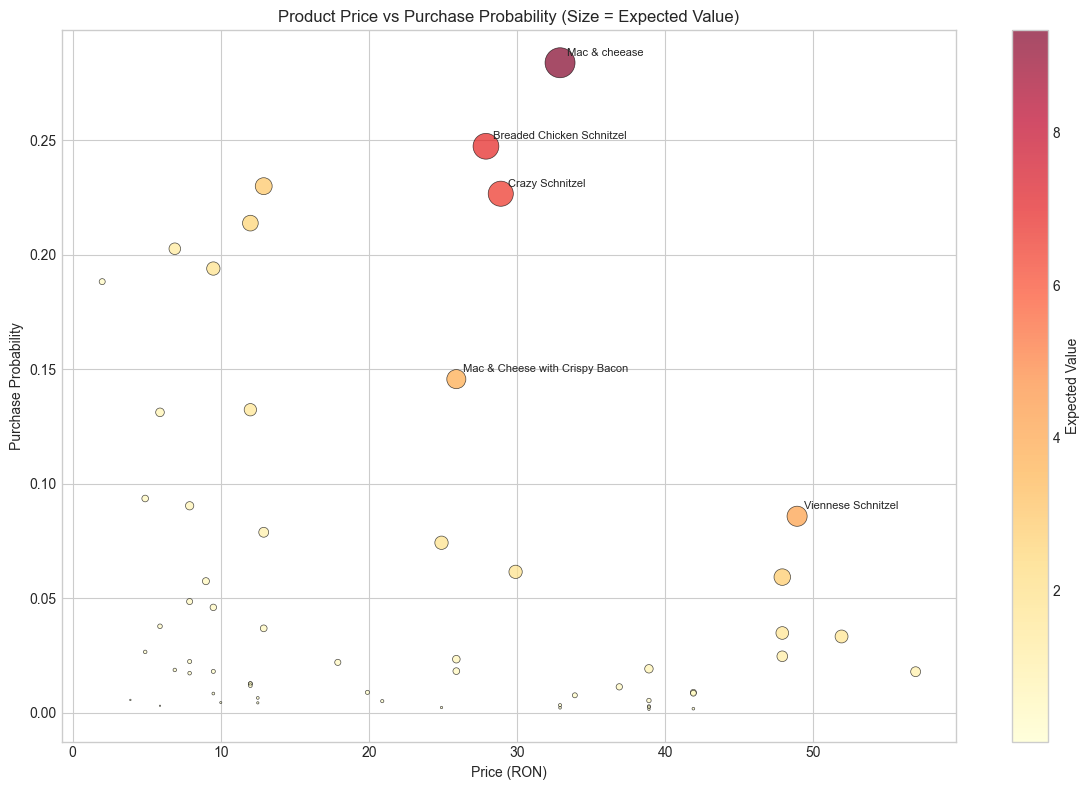

Saved: ranking_price_vs_probability.png


In [5]:
# Price vs Probability scatter
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(
    product_stats['price'], product_stats['purchase_probability'],
    s=product_stats['expected_value'] * 50,
    c=product_stats['expected_value'], cmap='YlOrRd',
    alpha=0.7, edgecolors='black', linewidth=0.5
)
plt.colorbar(scatter, label='Expected Value')
for _, row in product_stats.head(5).iterrows():
    ax.annotate(row['product'], (row['price'], row['purchase_probability']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax.set_xlabel('Price (RON)')
ax.set_ylabel('Purchase Probability')
ax.set_title('Product Price vs Purchase Probability (Size = Expected Value)')
plt.tight_layout()
plt.savefig('../results/ranking_price_vs_probability.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: ranking_price_vs_probability.png')

## 3. Category-Based Ranking

In [6]:
def categorize_product(name):
    name_lower = name.lower()
    if 'sauce' in name_lower: return 'Sauce'
    elif 'schnitzel' in name_lower: return 'Schnitzel'
    elif any(x in name_lower for x in ['fries', 'potatoes', 'baked']): return 'Sides'
    elif any(x in name_lower for x in ['pepsi', 'cola', 'aqua', '7up', 'lipton', 'mirinda', 'dew', 'prigat']): return 'Drinks'
    elif 'salad' in name_lower: return 'Salad'
    elif 'mac' in name_lower: return 'Mac & Cheese'
    else: return 'Other'

product_stats['category'] = product_stats['product'].apply(categorize_product)
print("Categories:", product_stats['category'].value_counts().to_dict())

Categories: {'Schnitzel': 14, 'Sauce': 14, 'Drinks': 13, 'Other': 8, 'Sides': 5, 'Salad': 3, 'Mac & Cheese': 2}


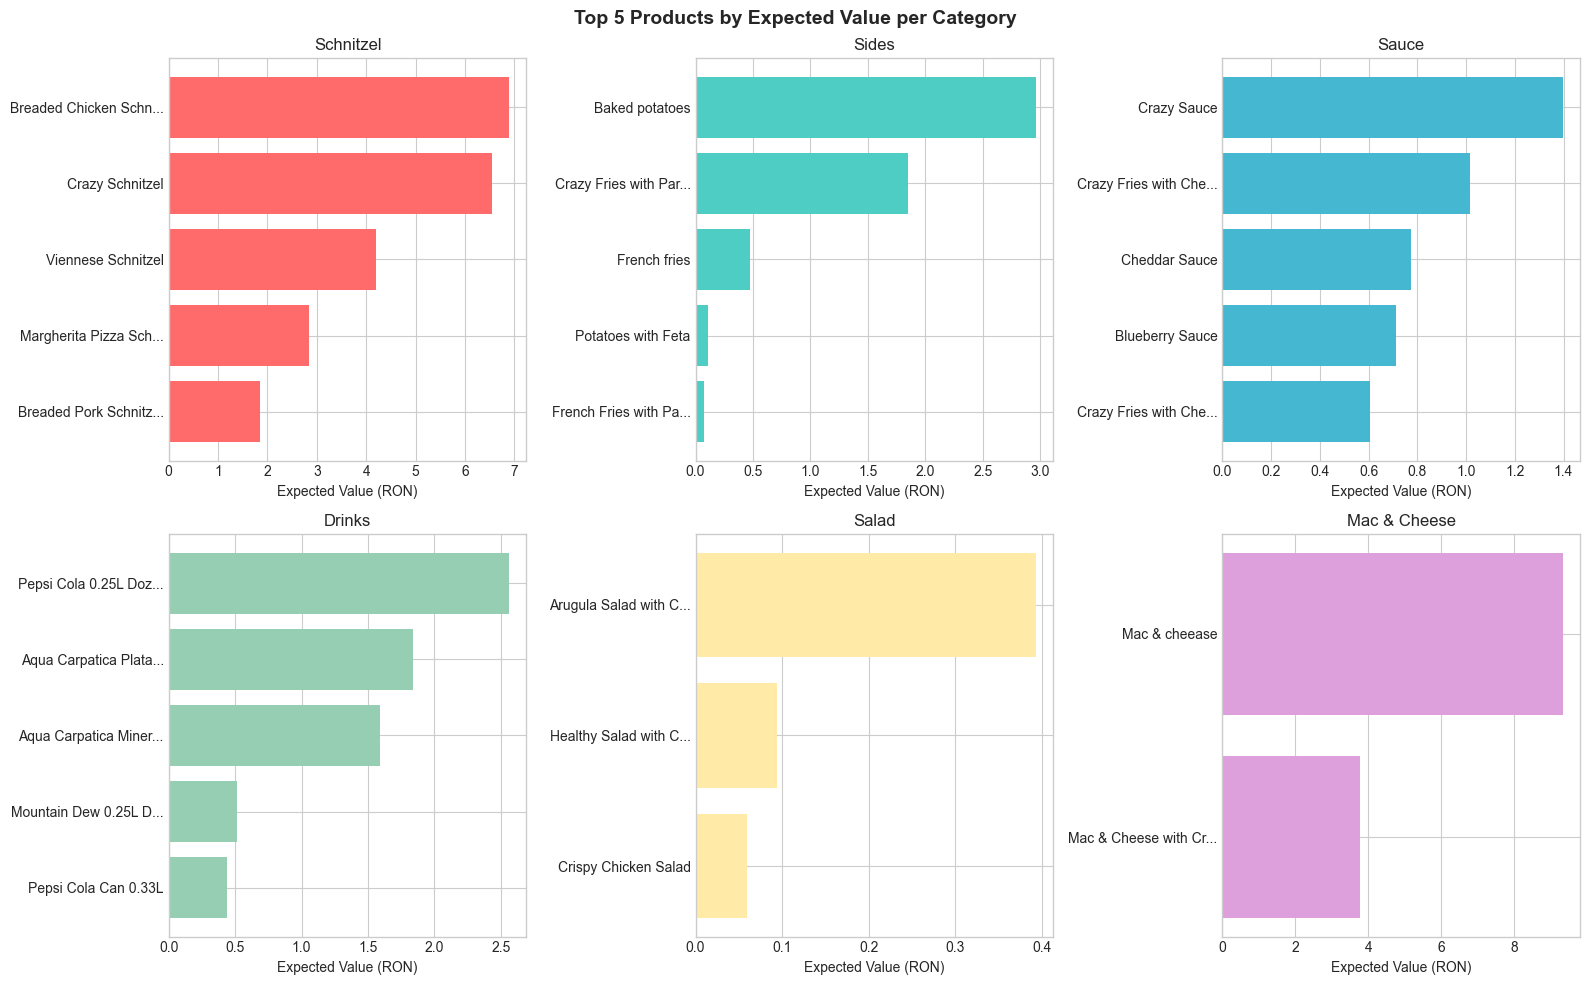

Saved: ranking_by_category.png


In [7]:
# Category visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()
categories = ['Schnitzel', 'Sides', 'Sauce', 'Drinks', 'Salad', 'Mac & Cheese']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']

for ax, category, color in zip(axes, categories, colors):
    cat_data = product_stats[product_stats['category'] == category].head(5)
    if len(cat_data) > 0:
        ax.barh(range(len(cat_data)), cat_data['expected_value'], color=color)
        ax.set_yticks(range(len(cat_data)))
        ax.set_yticklabels([p[:20] + '...' if len(p) > 20 else p for p in cat_data['product']])
        ax.set_xlabel('Expected Value (RON)')
        ax.set_title(f'{category}')
        ax.invert_yaxis()
    else:
        ax.text(0.5, 0.5, 'No products', ha='center', va='center')
        ax.set_title(f'{category}')

plt.suptitle('Top 5 Products by Expected Value per Category', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/ranking_by_category.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: ranking_by_category.png')

## 4. Contextual Ranking (Crazy Schnitzel)

In [8]:
# OPTIMIZED: Fast conditional EV calculation using merge
def get_conditional_ev_fast(df, given_product):
    """Fast conditional expected value using pandas operations."""
    # Get receipts with given product
    given_receipts = set(df[df['retail_product_name'] == given_product]['id_bon'].unique())
    n_given = len(given_receipts)
    
    if n_given == 0:
        return pd.DataFrame()
    
    # Filter and count
    filtered = df[df['id_bon'].isin(given_receipts)]
    counts = filtered.groupby('retail_product_name')['id_bon'].nunique().reset_index()
    counts.columns = ['product', 'count_with']
    
    # Get prices
    prices = df.groupby('retail_product_name')['SalePriceWithVAT'].first().reset_index()
    prices.columns = ['product', 'price']
    
    # Merge and calculate
    result = counts.merge(prices, on='product')
    result = result[result['product'] != given_product]
    result['conditional_probability'] = result['count_with'] / n_given
    result['conditional_expected_value'] = result['conditional_probability'] * result['price']
    
    return result.sort_values('conditional_expected_value', ascending=False)

# Calculate for Crazy Schnitzel
cs_recommendations = get_conditional_ev_fast(df, 'Crazy Schnitzel')
print("Top 10 Upsell for Crazy Schnitzel:")
cs_recommendations.head(10)

Top 10 Upsell for Crazy Schnitzel:


,product,count_with,price,conditional_probability,conditional_expected_value
36,Mac & cheease,880,32.9,0.493550,16.237801
4,Baked potatoes,656,12.9,0.367919,4.746158
41,Pepsi Cola 0.25L Doze,646,12.0,0.362311,4.347729
15,Crazy Sauce,948,6.9,0.531688,3.668648
2,Aqua Carpatica Plata 0.5L,461,9.5,0.258553,2.456254
1,Aqua Carpatica Minerala 0.5L,346,12.0,0.194055,2.328660
6,Breaded Chicken Schnitzel,125,27.9,0.070107,1.955973
34,Mac & Cheese with Crispy Bacon,109,25.9,0.061133,1.583343
13,Crazy Fries with Parmesan,109,24.9,0.061133,1.522210
57,Viennese Schnitzel,42,48.9,0.023556,1.151879


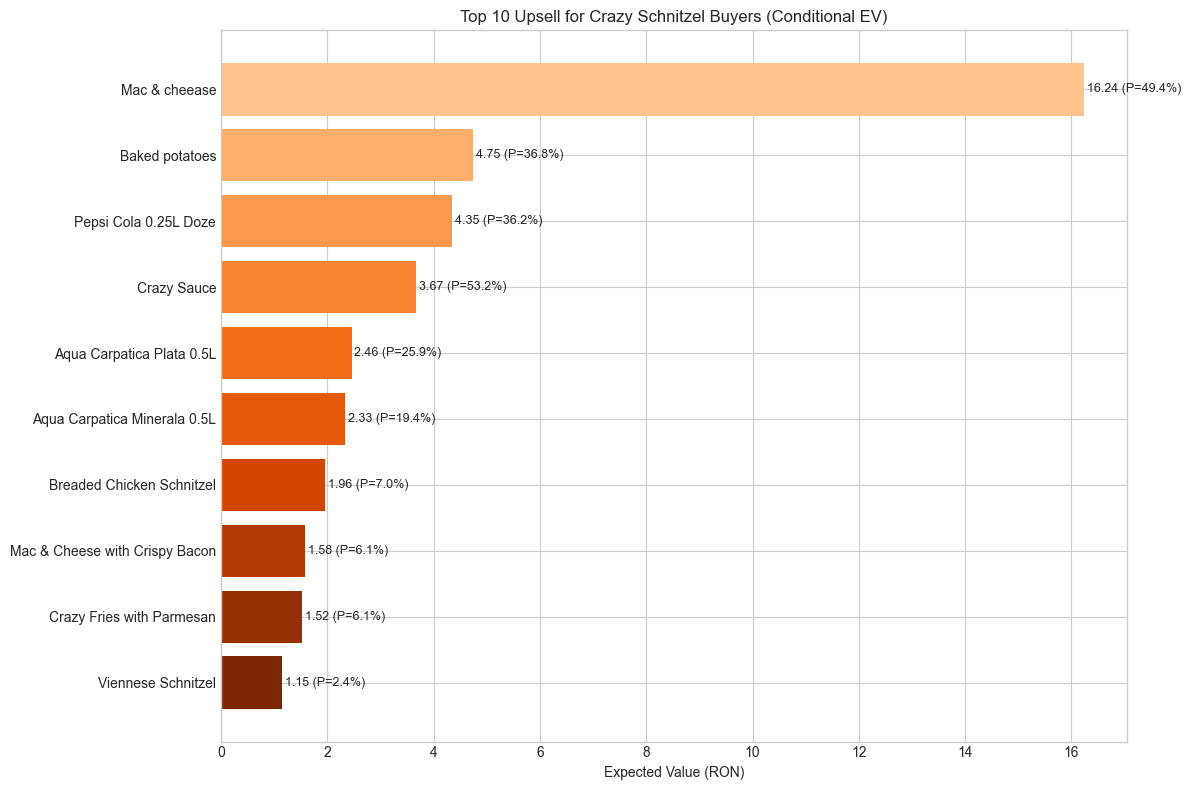

Saved: ranking_crazy_schnitzel_upsell.png


In [9]:
# Visualize
top_10 = cs_recommendations.head(10)

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Oranges(np.linspace(0.3, 1, len(top_10)))
ax.barh(range(len(top_10)), top_10['conditional_expected_value'], color=colors)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['product'])
ax.set_xlabel('Expected Value (RON)')
ax.set_title('Top 10 Upsell for Crazy Schnitzel Buyers (Conditional EV)')
ax.invert_yaxis()
for i, (v, p) in enumerate(zip(top_10['conditional_expected_value'], top_10['conditional_probability'])):
    ax.text(v + 0.05, i, f'{v:.2f} (P={p:.1%})', va='center', fontsize=9)
plt.tight_layout()
plt.savefig('../results/ranking_crazy_schnitzel_upsell.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: ranking_crazy_schnitzel_upsell.png')

## 5. Sauce Ranking

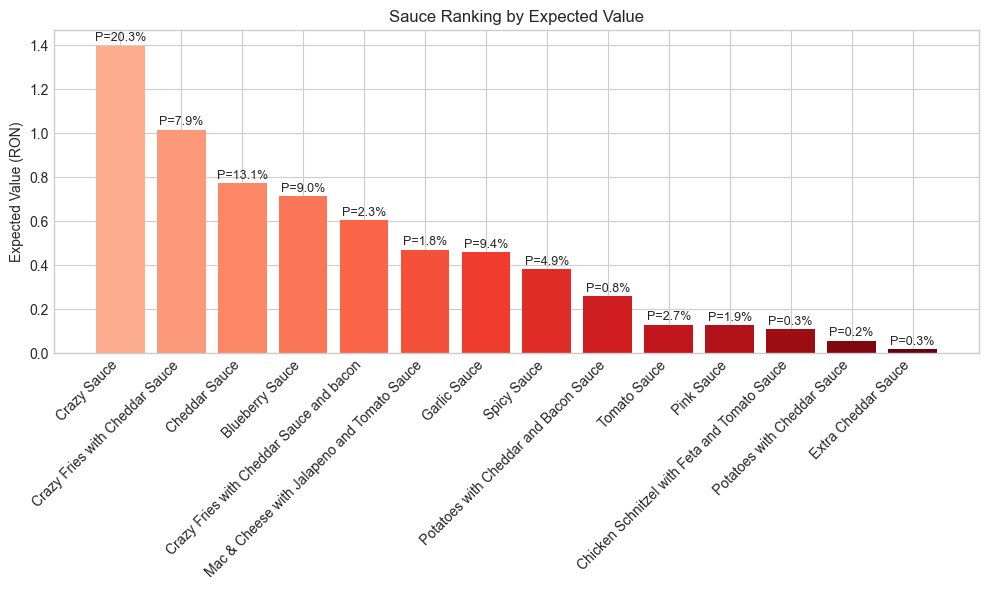

Saved: ranking_sauce_ev.png


In [10]:
sauce_stats = product_stats[product_stats['category'] == 'Sauce'].copy()

fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.Reds(np.linspace(0.3, 1, len(sauce_stats)))
ax.bar(range(len(sauce_stats)), sauce_stats['expected_value'], color=colors)
ax.set_xticks(range(len(sauce_stats)))
ax.set_xticklabels(sauce_stats['product'], rotation=45, ha='right')
ax.set_ylabel('Expected Value (RON)')
ax.set_title('Sauce Ranking by Expected Value')
for i, (v, p) in enumerate(zip(sauce_stats['expected_value'], sauce_stats['purchase_probability'])):
    ax.text(i, v + 0.02, f'P={p:.1%}', ha='center', fontsize=9)
plt.tight_layout()
plt.savefig('../results/ranking_sauce_ev.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: ranking_sauce_ev.png')

## 6. Summary

In [11]:
print("=" * 70)
print("PRODUCT RANKING SUMMARY")
print("=" * 70)
print(f"\nDataset: {len(df):,} transactions, {total_receipts:,} receipts")
print(f"Products analyzed: {len(product_stats)}")
print("\nTop 5 Products (General):")
for _, row in product_stats.head(5).iterrows():
    print(f"  {row['product']:35s} EV: {row['expected_value']:.2f} RON")
print(f"\nBest Sauce: {sauce_stats.iloc[0]['product']} (EV: {sauce_stats.iloc[0]['expected_value']:.2f})")
print("=" * 70)
print("\n✅ All graphs saved to results/ folder!")

PRODUCT RANKING SUMMARY

Dataset: 28,039 transactions, 7,869 receipts
Products analyzed: 59

Top 5 Products (General):
  Mac & cheease                       EV: 9.34 RON
  Breaded Chicken Schnitzel           EV: 6.90 RON
  Crazy Schnitzel                     EV: 6.55 RON
  Viennese Schnitzel                  EV: 4.19 RON
  Mac & Cheese with Crispy Bacon      EV: 3.77 RON

Best Sauce: Crazy Sauce (EV: 1.40)

✅ All graphs saved to results/ folder!
